In [1]:
# Установка необходимых библиотек

# Linux
# !pip install numpy matplotlib torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Windows
# !pip install numpy matplotlib torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# MacOS
# !pip install numpy matplotlib torch torchvision torchaudio

In [78]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from typing import List, Any
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

Скачивание датасета с помощью `torchvision`

In [79]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

In [80]:
valid_size = 10000 # глобальный параметр
train_size = len(dataset) - valid_size
# Подготовка тренировочного и валидационного датасетов
train_ds, valid_ds = random_split(dataset, [train_size, valid_size])
len(train_ds), len(valid_ds)

(50000, 10000)

In [81]:
batch_size = 256 # глобальный параметр

In [82]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(valid_ds, batch_size * 2, num_workers=4, pin_memory=True)

Функция для вычисления точности

In [83]:
def accuracy(outputs, labels) -> torch.Tensor:
    _, pred = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(pred == labels).item() / len(pred))

## Модель
Сделаем модель на основе `nn.Module`

In [84]:
class MnistModel(nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        self.linear1 = nn.Linear(in_size, hidden_size)  # hidden layer
        self.linear2 = nn.Linear(hidden_size, out_size) # output layer

    def forward(self, raw_input) -> torch.Tensor:
        raw_input = raw_input.view(raw_input.size(0), -1)   # конвертация изображения в тензор
        out = self.linear1(raw_input)                       # применение первого слоя -> промежуточная матрица
        out = F.relu(out)                                   # применение активационной функции
        out = self.linear2(out)                             # применение второго слоя -> результаты
        return out

    def training_step(self, batch) -> torch.Tensor:
        images, labels = batch
        out = self(images)                     # получение предсказания
        loss = F.cross_entropy(out, labels)    # вычисление потерь
        return loss

    def validation_step(self, batch) -> dict[str, Any]:
        images, labels = batch
        out = self(images)                    # получение предсказания
        loss = F.cross_entropy(out, labels)   # вычисление потерь
        acc = accuracy(out, labels)           # вычисление точности
        return {'validation loss': loss, 'validation accuracy': acc}

    def validation_epoch_end(self, outputs: dict[str, Any]) -> dict[str, Any]:
        batch_losses = [output['validation loss'] for output in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # объединение потерь
        batch_acc = [output['validation accuracy'] for output in outputs]
        epoch_acc = torch.stack(batch_acc).mean()      # объединение точности
        return {'validation loss': epoch_loss.item(), 'validation accuracy': epoch_acc.item()}

    def epoch_end(self, epoch: int, res: dict[str, Any]):
        print(f"Epoch [{epoch}], validation loss: {res['validation loss']:.4f}, validation accuracy: {res['validation accuracy']:.4f}")

Зададим параметры модели

In [85]:
input_size = 784
hidden_size = 32 # глобальный параметр
num_classes = 10

## Тренировка модели

Создадим функции `fit` и `evaluate` для тренировки модели с помощью градиентного спуска и оценки результатов на валидационном датасете.

In [86]:
def evaluate(model: MnistModel, val_loader: DataLoader) ->  dict[str, Any]:
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs: int, lr: float, model: MnistModel, train_loader: DataLoader, val_loader: DataLoader, opt_func=torch.optim.SGD) -> List[dict[str, Any]]:
    this_history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # тренировка
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # валидация
        res = evaluate(model, val_loader)
        model.epoch_end(epoch, res)
        this_history.append(res)
    return this_history

Инициализируем модель

In [91]:
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)

In [92]:
history = [evaluate(model, val_loader)]
history

[{'validation loss': 2.303105592727661,
  'validation accuracy': 0.13609835505485535}]

Изначальная точность должна быть около 10%, так как шанс угадать случальное число от 0 до 9 равен 1/10

Начнем тренировать модель.

Сначала возьмем коэффициент скорости обучения за 0.5

In [93]:
history += fit(10, 0.5, model, train_loader, val_loader)

Epoch [0], validation loss: 0.4077, validation accuracy: 0.8706
Epoch [1], validation loss: 0.2710, validation accuracy: 0.9217
Epoch [2], validation loss: 0.3318, validation accuracy: 0.8958
Epoch [3], validation loss: 0.1818, validation accuracy: 0.9468
Epoch [4], validation loss: 0.1910, validation accuracy: 0.9448
Epoch [5], validation loss: 0.1865, validation accuracy: 0.9450
Epoch [6], validation loss: 0.2362, validation accuracy: 0.9283
Epoch [7], validation loss: 0.1682, validation accuracy: 0.9508
Epoch [8], validation loss: 0.1503, validation accuracy: 0.9543
Epoch [9], validation loss: 0.1407, validation accuracy: 0.9600


Мы быстро приходим к точности 96%, теперь возьмем скорость обучения за 0.1

In [94]:
history += fit(10, 0.1, model, train_loader, val_loader)

Epoch [0], validation loss: 0.1225, validation accuracy: 0.9648
Epoch [1], validation loss: 0.1201, validation accuracy: 0.9657
Epoch [2], validation loss: 0.1195, validation accuracy: 0.9659
Epoch [3], validation loss: 0.1196, validation accuracy: 0.9666
Epoch [4], validation loss: 0.1196, validation accuracy: 0.9664
Epoch [5], validation loss: 0.1201, validation accuracy: 0.9650
Epoch [6], validation loss: 0.1201, validation accuracy: 0.9653
Epoch [7], validation loss: 0.1177, validation accuracy: 0.9667
Epoch [8], validation loss: 0.1179, validation accuracy: 0.9660
Epoch [9], validation loss: 0.1187, validation accuracy: 0.9660


Попробуем еще немного улучшить результат, взяв скорость обучения за 0.01

In [95]:
history += fit(10, 0.01, model, train_loader, val_loader)

Epoch [0], validation loss: 0.1170, validation accuracy: 0.9660
Epoch [1], validation loss: 0.1170, validation accuracy: 0.9659
Epoch [2], validation loss: 0.1170, validation accuracy: 0.9659
Epoch [3], validation loss: 0.1170, validation accuracy: 0.9660
Epoch [4], validation loss: 0.1170, validation accuracy: 0.9661
Epoch [5], validation loss: 0.1169, validation accuracy: 0.9660
Epoch [6], validation loss: 0.1169, validation accuracy: 0.9661
Epoch [7], validation loss: 0.1169, validation accuracy: 0.9663
Epoch [8], validation loss: 0.1168, validation accuracy: 0.9660
Epoch [9], validation loss: 0.1169, validation accuracy: 0.9657


Посмотрим, как менялись результаты работы за каждую эпоху

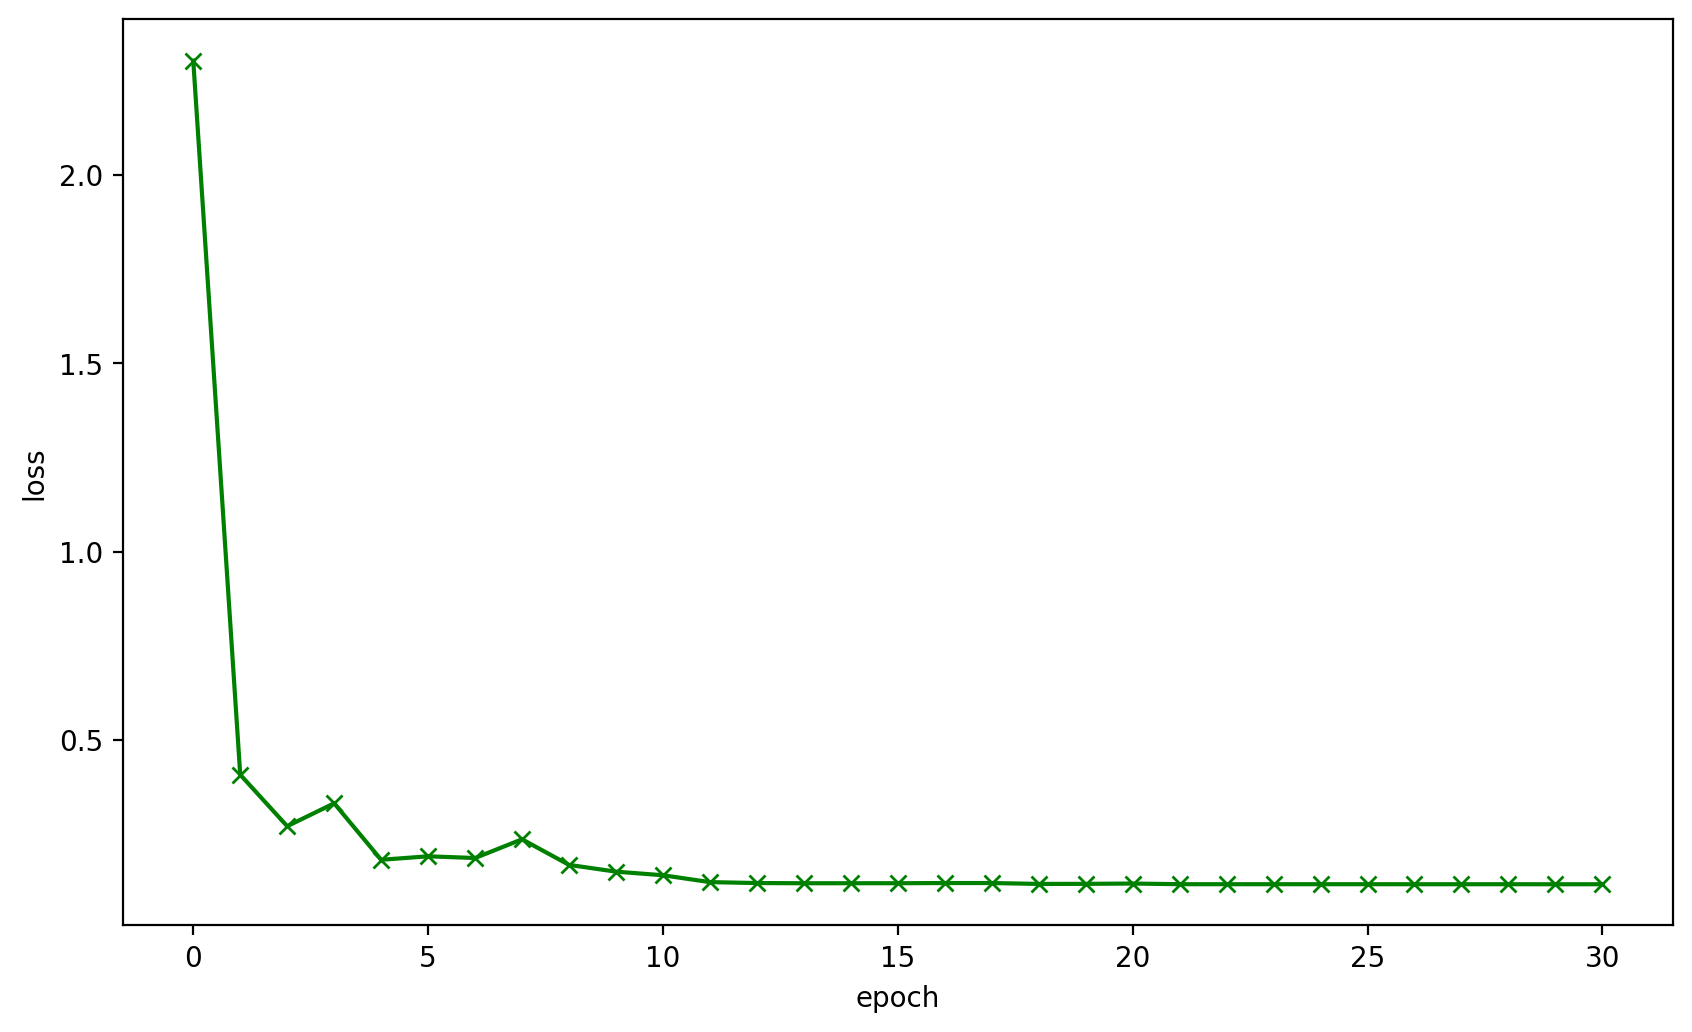

In [96]:
losses = [d['validation loss'] for d in history]
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)
ax.plot(losses, '-x', color='green')
ax.set_xlabel('epoch')
ax.set_ylabel('loss');

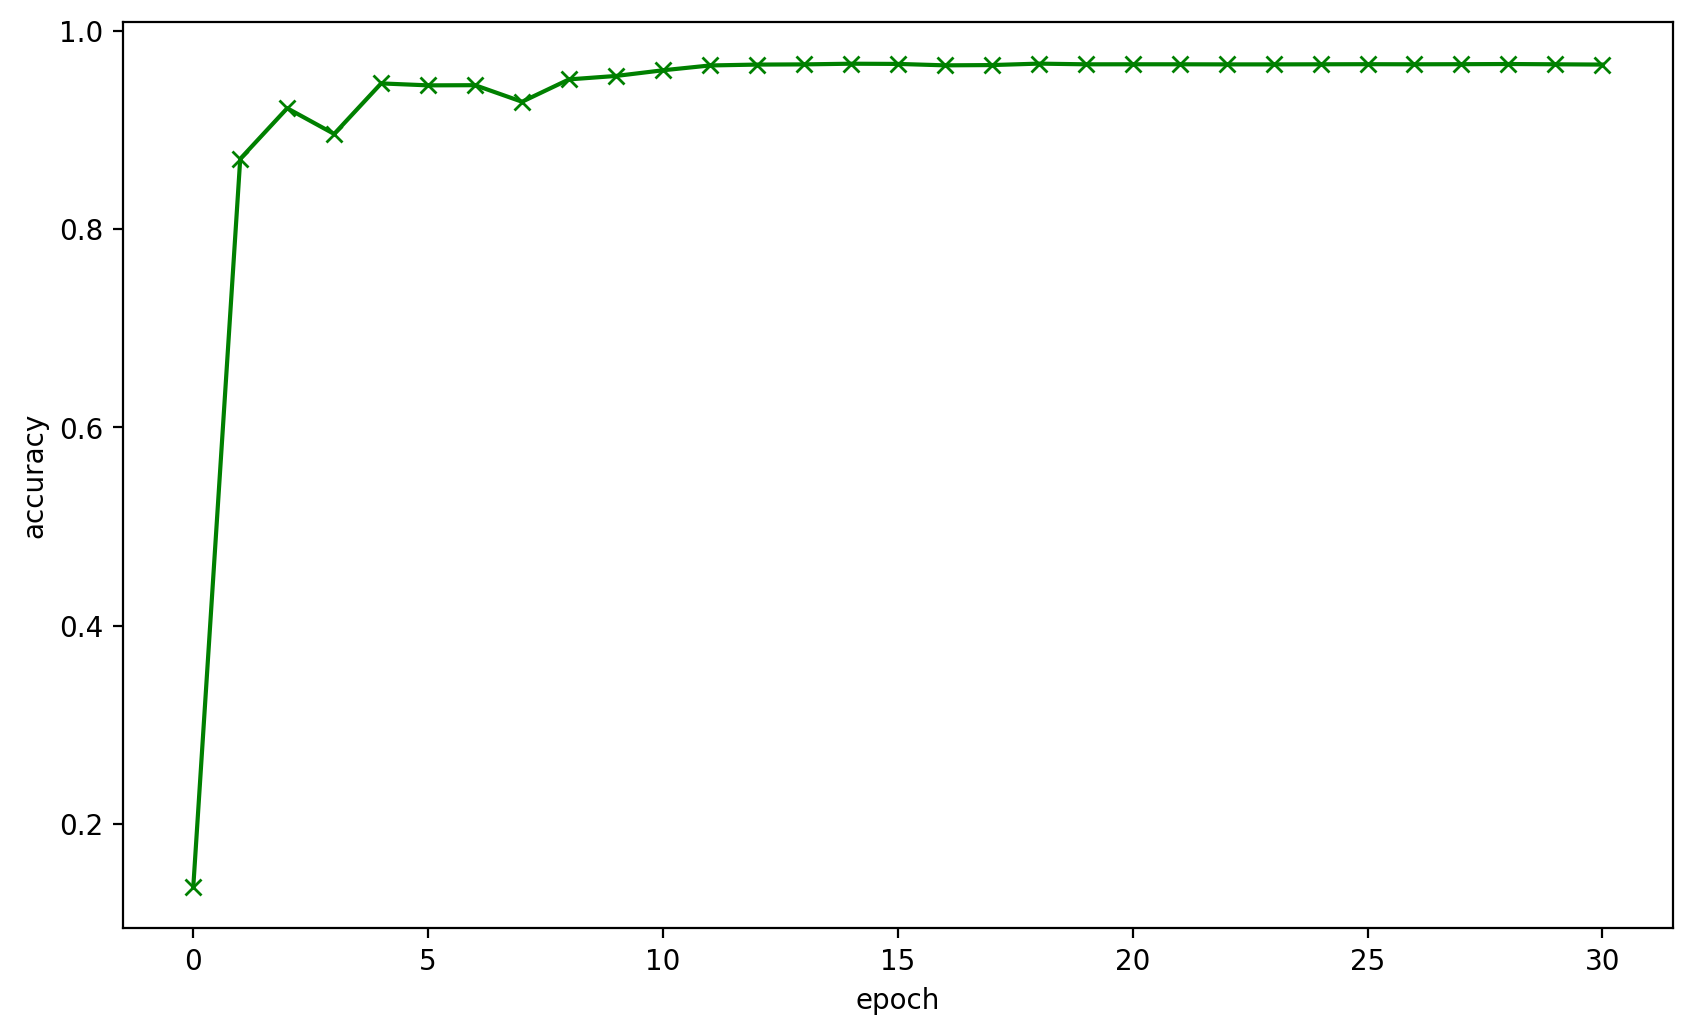

In [97]:
accuracies = [d['validation accuracy'] for d in history]
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)
ax.plot(accuracies, '-x', color='green')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy');

## Тестирование на отдельных изображениях


In [98]:
test_dataset = MNIST(root='data/', train=False, transform=ToTensor()) # подготовим тренировочный датасет
len(test_dataset)

10000

Создадим функцию `predict_image`, которая возвращает предположение модели для одного изображения.

In [99]:
def predict_image(img, model: MnistModel) -> int:
    raw = img.unsqueeze(0)
    out = model(raw)
    _, preds  = torch.max(out, dim=1)
    return preds[0].item()

Протестируем на отдельных элементах датасета

Label: 5 , Predicted: 5


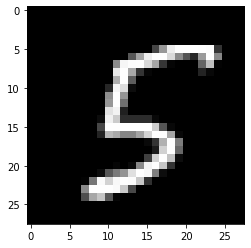

In [100]:
img, label = test_dataset[23]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 1 , Predicted: 1


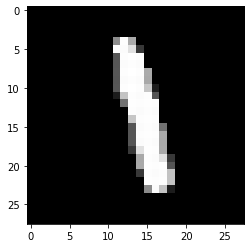

In [101]:
img, label = test_dataset[2136]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 9


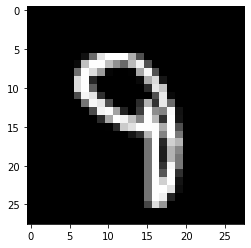

In [102]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Посмотрим, как эффективна наша нейросеть на тестовом датасете

In [103]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'validation loss': 0.10101385414600372,
 'validation accuracy': 0.969531238079071}

Как видно, результаты близки к тем, что мы получили на валидационном датасете.

In [104]:
torch.save(model.state_dict(), 'model.pth')

# Для загрузки полученной модели - закомментировать код выше и раскомментировать код ниже.

# model = MnistModel(input_size, hidden_size=32, out_size=num_classes)
# model.load_state_dict(torch.load('model.pth'))